# Hyperparameters and lags search: backtesting vs one-step-ahead

Hyperparameter and lag tuning involves systematically testing different values or combinations of hyperparameters (and/or lags) to find the optimal configuration that gives the best performance. The **skforecast** library provides two different methods to evaluate each candidate configuration:

+ **Backtesting**: In this method, the model predicts several steps ahead in each iteration, using the same forecast horizon and retraining frequency strategy that would be used if the model were deployed. This simulates a real forecasting scenario where the model is retrained and updated over time.

+ **One-Step Ahead**: Evaluates the model using only one-step-ahead predictions. This method is faster because it requires fewer iterations, but it only tests the model's performance in the immediate next time step.

Each method uses a different evaluation strategy, so they may produce different results. However, in the long run, both methods are expected to converge to similar selections of optimal hyperparameters. The one-step-ahead method is much faster than backtesting because it requires fewer iterations, but it only tests the model's performance in the immediate next time step. It is recommended to backtest the final model for a more accurate multi-step performance estimate.

The document compares the performance of these two methods when applied to various datasets and forecaster types. The process is outlined as follows:

+ Optimal hyperparameters and lags are identified through a search using both backtesting and one-step-ahead evaluation methods. This search is performed on the validation partition, and the best configuration is stored along with the time taken to complete the search.

+ Finally, the selected best configuration is evaluated on the test partition using a backtesting procedure.

It is important to note that the final evaluation is consistently performed using backtesting to simulate a real-world multi-step forecasting scenario.

## Results

The results show a significant reduction in the time required to find the optimal configuration using the one-step-ahead method (top panel). However, the performance of the selected configuration on the test partition is similar for both methods (lower panel), with no clear winner. These results are consistent for both grid search and Bayesian search approaches.

<div style="text-align: center;">
    <img src="../img/grid_search_benchmarck.png" alt="Grid Search Results" width="700"/>
</div>

<div style="text-align: center;">
    <img src="../img/bayesian_search_benchmarck.png" alt="Grid Search Results" width="700"/>
</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The purpose of this analysis is to compare the time and forecasting performance of the two available evaluation methods, not to compare different forecasters.

</div>

## Libraries

In [2]:
# Libraries
# ==============================================================================
import platform
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from copy import copy
import sklearn
import skforecast
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict

# Warnings
# ==============================================================================
import warnings
from skforecast.exceptions import IgnoredArgumentWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', category=IgnoredArgumentWarning)

In [3]:
# Versions
# ==============================================================================
print(f"Python version      : {platform.python_version()}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"skforecast version  : {skforecast.__version__}")
print(f"lightgbm version    : {lightgbm.__version__}")
print(f"pandas version      : {pd.__version__}")
print(f"numpy version       : {np.__version__}")
print(f"psutil version      : {psutil.__version__}")
print("")

# System information
# ==============================================================================
print(f"Machine type: {platform.machine()}")
print(f"Processor type: {platform.processor()}")
print(f"Platform type: {platform.platform()}")
print(f"Operating system: {platform.system()}")
print(f"Operating system release: {platform.release()}")
print(f"Operating system version: {platform.version()}")
print(f"Number of physical cores: {psutil.cpu_count(logical=False)}")
print(f"Number of logical cores: {psutil.cpu_count(logical=True)}")

Python version      : 3.12.4
scikit-learn version: 1.5.1
skforecast version  : 0.14.0
lightgbm version    : 4.4.0
pandas version      : 2.2.2
numpy version       : 1.26.4
psutil version      : 5.9.0

Machine type: x86_64
Processor type: x86_64
Platform type: Linux-5.15.0-1070-aws-x86_64-with-glibc2.31
Operating system: Linux
Operating system release: 5.15.0-1070-aws
Operating system version: #76~20.04.1-Ubuntu SMP Mon Sep 2 12:20:36 UTC 2024
Number of physical cores: 4
Number of logical cores: 8


## Data sets

In [4]:
# Import data
# ==============================================================================
data_bike = fetch_dataset('bike_sharing_extended_features', verbose=False)
data_sales = fetch_dataset(name="items_sales", verbose=False)
data_sales = data_sales * 100
data_sales['day_of_week'] = data_sales.index.dayofweek

data_website = fetch_dataset(name="website_visits", raw=True, verbose=False)
data_website['date'] = pd.to_datetime(data_website['date'], format='%d/%m/%y')
data_website = data_website.set_index('date')
data_website = data_website.asfreq('1D')
data_website = data_website.sort_index()
data_website['month'] = data_website.index.month
data_website['month_day'] = data_website.index.day
data_website['week_day'] = data_website.index.day_of_week
data_website = pd.get_dummies(data_website, columns=['month', 'week_day', 'month_day'], dtype='int64')

data_electricity = fetch_dataset(name='vic_electricity', raw=False, verbose=False)
data_electricity = data_electricity.drop(columns="Date")
data_electricity = (
    data_electricity
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data_electricity = data_electricity.loc['2012-01-01 00:00:00': '2013-12-30 23:00:00'].copy()


series_dict = pd.read_csv(
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/demo_multi_series.csv'
)
exog_dict = pd.read_csv(
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast-datasets/main/data/demo_multi_series_exog.csv'
)
series_dict ['timestamp'] = pd.to_datetime(series_dict ['timestamp'])
exog_dict['timestamp'] = pd.to_datetime(exog_dict['timestamp'])
series_dict = series_long_to_dict(
    data      = series_dict,
    series_id = 'series_id',
    index     = 'timestamp',
    values    = 'value',
    freq      = 'D'
)
exog_dict = exog_long_to_dict(
    data      = exog_dict,
    series_id = 'series_id',
    index     = 'timestamp',
    freq      = 'D'
)

## Benchmark

In [5]:
# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark(
    data,
    forecaster_to_benchmark,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    target = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search and bayesian search using backtesting and one-step-ahead.
    """
    
    # backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_1, pred_1 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, target],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_2, pred_2 = backtesting_forecaster(
                        forecaster          = forecaster,
                        y                   = data.loc[:, target],
                        exog                = data.loc[:, exog_features] if exog_features else None,
                        initial_train_size  = len(data.loc[:end_validation]),
                        steps               = steps,
                        metric              = metric,
                        verbose             = False,
                        show_progress       = False
                        )

    print("-----------------")
    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric}: {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric}: {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


# Functions to compare results using backtesting and one step ahead
# ==============================================================================
def run_benchmark_multiseries(
    data = None,
    forecaster_to_benchmark = None,
    search_method = None,
    lags_grid = None,
    param_grid = None,
    search_space = None,
    end_train = None,
    end_validation = None,
    levels = None,
    exog_features = None,
    steps = None,
    metric = None
):
    """
    Compare results of grid search using backtesting and one-step-ahead.
    """
    
    # Backtesting
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_1 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        levels             = levels,
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_1, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        search_space       = search_space,
                        steps              = steps,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False
                    )
    end = time()
    time_1 = end - start
    best_params = results_1.loc[0, 'params']
    best_lags = results_1.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_1, pred_1 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            initial_train_size  = len(data.loc[:end_validation]),
                            levels              = levels,
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    # One step ahead
    forecaster = copy(forecaster_to_benchmark)
    start  = time()
    if search_method == 'grid_search':
        results_2 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )
    else:
        results_2, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = data.loc[:end_validation, levels],
                        exog               = data.loc[:end_validation, exog_features] if exog_features else None,
                        levels             = levels,
                        steps              = steps,
                        search_space       = search_space,
                        metric             = metric,
                        initial_train_size = len(data.loc[:end_train]),
                        method             = 'one_step_ahead',
                        n_trials           = 15,
                        random_state       = 123,
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False
                    )

    end = time()
    time_2 = end - start
    best_params = results_2.loc[0, 'params']
    best_lags = results_2.loc[0, 'lags']
    forecaster.set_params(best_params)
    forecaster.set_lags(lags=best_lags)
    metric_2, pred_2 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = data.loc[:, levels],
                            exog                = data.loc[:, exog_features] if exog_features else None,
                            levels              = levels,
                            initial_train_size  = len(data.loc[:end_validation]),
                            steps               = steps,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False
                        )

    print("Benchmark results")
    print("-----------------")
    print('Execution time backtesting   :', time_1)
    print('Execution time one step ahead:', time_2)
    print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
    print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
    print("")
    print("Method: backtesting")
    print(f"    lags   : {results_1.loc[0, 'lags']}")
    print(f"    params : {results_1.loc[0, 'params']}")
    print(f"    {metric_1.loc[0, metric]}")
    print("")
    print("Method: one step ahead")
    print(f"    lags   : {results_2.loc[0, 'lags']}")
    print(f"    params : {results_2.loc[0, 'params']}")
    print(f"    {metric_2.loc[0, metric]}")
    
    return time_1, time_2, metric_1.loc[0, metric], metric_2.loc[0, metric]


def summarize_results(results, metric, title, plot=True, save_plot=None, fig_size=(8, 4)):
    """
    Summarize results of benchmark.
    """

    results = pd.DataFrame(
        results,
        columns=[
            "dataset",
            "forecaster",
            "time_search_backtesting",
            "time_search_one_step",
            "metric_backtesting",
            "metric_one_step",
        ]
    )
    results['ratio_speed'] = (
        results['time_search_backtesting'] / results['time_search_one_step']
    ).round(2)
    results['ratio_metric'] = (
        results['metric_backtesting'] / results['metric_one_step']
    ).round(2)
    results["dataset_forecaster"] = (
        results["dataset"]
        + " \n "
        + results["forecaster"].str.replace("Forecaster", "")
    )
    display(results)

    if plot:
        set_dark_theme()
        fig, axs = plt.subplots(2, 1, figsize=fig_size, sharex=True)
        results.plot.bar(
            x='dataset_forecaster',
            y=['time_search_backtesting', 'time_search_one_step'],
            ax=axs[0],
        )
        axs[0].set_ylabel('time (s)')
        axs[0].legend(["backtesting", "one-step-ahead"])
        results.plot.bar(
            x='dataset_forecaster',
            y=['metric_backtesting', 'metric_one_step'],
            ax=axs[1],
            legend=False
        )
        axs[1].set_ylabel(f'{metric}')
        axs[1].set_xlabel('')
        plt.xticks(rotation=90)
        plt.suptitle(title)
        plt.tight_layout()

        if save_plot:
            plt.savefig(save_plot, dpi=300, bbox_inches='tight')

### Grid search

In [6]:
# Results
# ==============================================================================
results_grid_search = []
metric = 'mean_absolute_error'

In [7]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )
lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)

results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 78.62683033943176
Execution time one step ahead: 7.300451040267944
Same lags  : False
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 58.276762590192014

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
    mean_absolute_error: 64.04254202108999


In [8]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'bike',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 71.92292070388794
Execution time one step ahead: 1.4280896186828613
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 112.88378916846884}
    mean_absolute_error: 79.14111581771634

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 12.742749857031322}
    mean_absolute_error: 111.95615163625295


In [9]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 5.51067590713501
Execution time one step ahead: 0.4799065589904785
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 162.11396980738706

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 2.976351441631316}
    mean_absolute_error: 162.3516346601722


In [10]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(random_state=123),
                 steps     = 24,
                 lags      = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 12.132128715515137
Execution time one step ahead: 1.5563743114471436
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 277.8362513175169

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 1.438449888287663}
    mean_absolute_error: 236.28560218972729


In [11]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 76.80228281021118
Execution time one step ahead: 6.293450355529785
Same lags  : False
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 194.83553235066182

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
    mean_absolute_error: 188.8782299908785


In [12]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

param_grid = {'alpha': np.logspace(-3, 3, 20)}

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_grid_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

-----------------
Benchmark results
-----------------
Execution time backtesting   : 70.91320610046387
Execution time one step ahead: 1.4723453521728516
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 6.158482110660261}
    mean_absolute_error: 304.22332781257694

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 1.438449888287663}
    mean_absolute_error: 301.7070971763055


In [13]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = ['day_of_week']

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

Benchmark results
-----------------
Execution time backtesting   : 1.6487984657287598
Execution time one step ahead: 1.0693504810333252
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 200}
    137.16940500432474

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 3, 'n_estimators': 50}
    134.76669158338447


In [14]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = {
    '24 lags': 24,
    '48 lags': 48
}

param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'grid_search',
    lags_grid               = lags_grid,
    param_grid              = param_grid,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)

results_grid_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

Benchmark results
-----------------
Execution time backtesting   : 6.838553428649902
Execution time one step ahead: 1.404649019241333
Same lags  : False
Same params: True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
    params : {'max_depth': 7, 'n_estimators': 50}
    100.16441146410313

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'max_depth': 7, 'n_estimators': 50}
    95.20010578089475


In [15]:
# Dataset series_dict - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2016-05-31 23:59:00'
end_validation = '2016-07-31 23:59:00'
levels = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

forecaster_to_benchmark = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )
lags_grid = [7, 14]
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [3, 7]
}

# Backtesting
forecaster = copy(forecaster_to_benchmark)
start  = time()
results_1 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                        exog               = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 24,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = 100,
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False,
                        suppress_warnings  = True
                    )
end = time()
time_1 = end - start
best_params = results_1.loc[0, 'params']
best_lags = results_1.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)
metric_1, pred_1 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = series_dict,
                            exog                = exog_dict,
                            initial_train_size  = 213,
                            levels              = levels,
                            steps               = 24,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False,
                            suppress_warnings  = True
                        )

# One step ahead
forecaster = copy(forecaster_to_benchmark)
start  = time()
results_2 = grid_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                        exog               = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                        levels             = levels,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        metric             = metric,
                        initial_train_size = 100,
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False,
                        suppress_warnings  = True
                    )
end = time()
time_2 = end - start
best_params = results_2.loc[0, 'params']
best_lags = results_2.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)
metric_2, pred_2 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = series_dict,
                            exog                = exog_dict,
                            initial_train_size  = 213,
                            levels              = levels,
                            steps               = 24,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False,
                            suppress_warnings  = True
                        )
print("Benchmark results")
print("-----------------")
print('Execution time backtesting   :', time_1)
print('Execution time one step ahead:', time_2)
print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
print("")
print("Method: backtesting")
print(f"    lags   : {results_1.loc[0, 'lags']}")
print(f"    params : {results_1.loc[0, 'params']}")
print(f"    {metric_1.loc[0, metric]}")
print("")
print("Method: one step ahead")
print(f"    lags   : {results_2.loc[0, 'lags']}")
print(f"    params : {results_2.loc[0, 'params']}")
print(f"    {metric_2.loc[0, metric]}")

results_grid_search.append([
    'series_dict',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1.loc[0, metric],
    metric_2.loc[0, metric],
])

Benchmark results
-----------------
Execution time backtesting   : 1.6000556945800781
Execution time one step ahead: 0.3853023052215576
Same lags  : False
Same params: False

Method: backtesting
    lags   : [1 2 3 4 5 6 7]
    params : {'max_depth': 3, 'n_estimators': 50}
    180.46141171905165

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'max_depth': 7, 'n_estimators': 50}
    164.23659500870002


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,ratio_speed,ratio_metric,dataset_forecaster
0,bike,ForecasterAutoreg,78.626830,7.300451,58.276763,64.042542,10.77,0.91,bike \n Autoreg
1,bike,ForecasterAutoregDirect,71.922921,1.428090,79.141116,111.956152,50.36,0.71,bike \n AutoregDirect
2,website,ForecasterAutoreg,5.510676,0.479907,162.113970,162.351635,11.48,1.00,website \n Autoreg
3,website,ForecasterAutoregDirect,12.132129,1.556374,277.836251,236.285602,7.80,1.18,website \n AutoregDirect
4,electricity,ForecasterAutoreg,76.802283,6.293450,194.835532,188.878230,12.20,1.03,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,70.913206,1.472345,304.223328,301.707097,48.16,1.01,electricity \n AutoregDirect
6,sales,ForecasterAutoregMultiSeries,1.648798,1.069350,137.169405,134.766692,1.54,1.02,sales \n AutoregMultiSeries
7,sales,ForecasterAutoregMultiVariate,6.838553,1.404649,100.164411,95.200106,4.87,1.05,sales \n AutoregMultiVariate
8,series_dict,ForecasterAutoregMultiSeries,1.600056,0.385302,180.461412,164.236595,4.15,1.10,series_dict \n AutoregMultiSeries


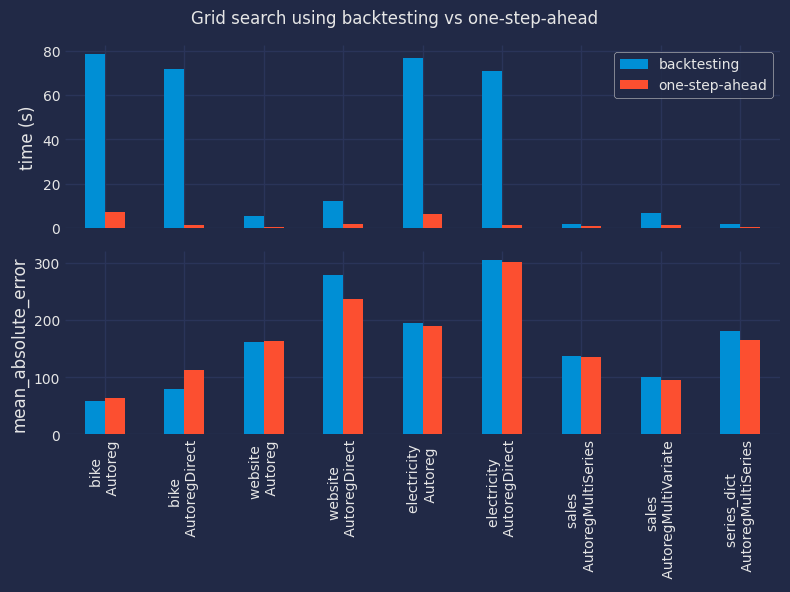

In [16]:
# Results
# ==============================================================================
summarize_results(
    results   = results_grid_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    title     = 'Grid search using backtesting vs one-step-ahead',
    save_plot = "../img/grid_search_benchmarck.png"
)

### Bayesian search

In [17]:
# Table to store results
# ==============================================================================
results_bayesian_search = []
metric = 'mean_absolute_error'

In [18]:
# Dataset bike_sharing_extended_features - ForecasterAutoreg
# ==============================================================================
end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
exog_features = [
    'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin',
    'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day',
    'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day',
    'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day',
    'temp', 'holiday'
]

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1739: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 81.104501247406
Execution time one step ahead: 28.4353928565979
Same lags  : True
Same params: True

Method: backtesting
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.2285821738161964, 'reg_alpha': 0.2379772800670556, 'reg_lambda': 0.9887301767538853}
    mean_absolute_error: 55.80577702511616

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.017833474222028703, 'gamma': 0.2285821738161964, 'reg_alpha': 0.2379772800670556, 'reg_lambda': 0.9887301767538853}
    mean_absolute_error: 55.80577702511616


In [19]:
# Dataset bike_sharing_extended_features - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 steps         = 24,
                 lags          = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_bike,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'bike_sharing',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1739: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 19.26004123687744
Execution time one step ahead: 1.4251313209533691
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 121.0898788312409}
    mean_absolute_error: 79.1498337214025

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'alpha': 15.094374246471325}
    mean_absolute_error: 111.96208734026862


In [20]:
# Dataset website_visits - ForecasterAutoreg
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'
exog_features = [col for col in data_website.columns if col.startswith(('month_', 'week_day_', 'month_day_'))]

forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1739: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 1.2653906345367432
Execution time one step ahead: 0.2625236511230469
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 136.76802274106467

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 173.5282998809151


In [21]:
# Dataset website_visits - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 7
             )

lags_grid = [7, 14, 21, [7, 14, 21]]

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_website,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'users',
    exog_features           = exog_features,
    steps                   = 7,
    metric                  = metric
)

results_bayesian_search.append([
    'website',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1739: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 1.5849392414093018
Execution time one step ahead: 0.3827948570251465
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
    params : {'alpha': 0.07474245141964296}
    mean_absolute_error: 139.40123604696382

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'alpha': 0.03182234592129467}
    mean_absolute_error: 153.6723680506666


In [22]:
# Dataset vic_electricity - ForecasterAutoreg
# ==============================================================================
end_train = '2013-06-30 23:59:00'
end_validation = '2013-11-30 23:59:00'
exog_features = ['Temperature', 'Holiday']

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 10
             )

lags_grid = [48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169)]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1739: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 92.89738893508911
Execution time one step ahead: 26.816620111465454
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'n_estimators': 1200, 'max_depth': 8, 'learning_rate': 0.020288327487155415, 'gamma': 0.9893221948178936, 'reg_alpha': 0.0026751307734329544, 'reg_lambda': 0.0033431281459104997}
    mean_absolute_error: 196.74829952595292

Method: one step ahead
    lags   : [  1   2   3  23  24  25 167 168 169]
    params : {'n_estimators': 1200, 'max_depth': 10, 'learning_rate': 0.056896300053531614, 'gamma': 0.2725691628660212, 'reg_alpha': 0.24605588251006993, 'reg_lambda': 0.9687485406819449}
    mean_absolute_error: 191.37491441780287


In [23]:
# Dataset vic_electricity - ForecasterAutoregDirect
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor     = Ridge(random_state=123),
                 transformer_y = StandardScaler(),
                 lags          = 10,
                 steps         = 24
             )

lags_grid = (48, 72, (1, 2, 3, 23, 24, 25, 167, 168, 169))

def search_space(trial):
    search_space  = {
        'alpha' : trial.suggest_float('alpha', 0.001, 1000, log=True),
        'lags'  : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space


time_1, time_2, metric_1, metric_2 = run_benchmark(
    data                    = data_electricity,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    target                  = 'Demand',
    exog_features           = exog_features,
    steps                   = 24,
    metric                  = metric
)
results_bayesian_search.append([
    'electricity',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection/model_selection.py:1739: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


-----------------
Benchmark results
-----------------
Execution time backtesting   : 17.570114374160767
Execution time one step ahead: 0.8226943016052246
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 16.432489069228232}
    mean_absolute_error: 307.13365278620506

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'alpha': 0.36149961722510493}
    mean_absolute_error: 300.87028133154746


In [24]:
# Dataset sales - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2014-05-15 23:59:00'
end_validation = '2014-07-15 23:59:00'
levels = ['item_1', 'item_2', 'item_3']
exog_features = ['day_of_week']

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 36,
    metric                  = metric
)
results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:2349: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


Benchmark results
-----------------
Execution time backtesting   : 3.5031938552856445
Execution time one step ahead: 2.78940486907959
Same lags  : True
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 199, 'max_depth': 3, 'learning_rate': 0.01901626315047264}
    135.45451272241843

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.06045266837878549}
    123.59899056676193


In [25]:
# Dataset sales - ForecasterAutoregMultiVariate
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 steps              = 5,
                 level              = 'item_1',
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

lags_grid = [48, 72]

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

time_1, time_2, metric_1, metric_2 = run_benchmark_multiseries(
    data                    = data_sales,
    forecaster_to_benchmark = forecaster,
    search_method           = 'bayesian_search',
    search_space            = search_space,
    end_train               = end_train,
    end_validation          = end_validation,
    levels                  = levels,
    exog_features           = exog_features,
    steps                   = 5,
    metric                  = metric
)
results_bayesian_search.append([
    'sales',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1,
    metric_2,
])

/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:83: IgnoredArgumentWarning: `levels` argument have no use when the forecaster is of type `ForecasterAutoregMultiVariate`. The level of this forecaster is 'item_1', to predict another level, change the `level` argument when initializing the forecaster. 
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(
/home/ubuntu/varios/skforecast/skforecast/model_

Benchmark results
-----------------
Execution time backtesting   : 21.014704942703247
Execution time one step ahead: 5.041488170623779
Same lags  : False
Same params: False

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
    params : {'n_estimators': 178, 'max_depth': 4, 'learning_rate': 0.029392307095288957}
    98.66981600939468

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
    params : {'n_estimators': 98, 'max_depth': 5, 'learning_rate': 0.23598059857016607}
    101.07276932380157


In [26]:
# Dataset series_dict - ForecasterAutoregMultiSeries
# ==============================================================================
end_train = '2016-05-31 23:59:00'
end_validation = '2016-07-31 23:59:00'
levels = ['id_1000', 'id_1001', 'id_1002', 'id_1003', 'id_1004']
series_dict_train = {k: v.loc[: end_train,] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: end_train,] for k, v in exog_dict.items()}
series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

forecaster_to_benchmark = ForecasterAutoregMultiSeries(
                 regressor          = LGBMRegressor(random_state=123, verbose=-1),
                 lags               = 24,
                 encoding           = "ordinal",
                 transformer_series = None,
                 transformer_exog   = None,
                 weight_func        = None,
                 series_weights     = None,
                 differentiation    = None,
                 dropna_from_series = False,
                 fit_kwargs         = None,
                 forecaster_id      = None
             )

def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 50, 200),
        'max_depth'       : trial.suggest_int('max_depth', 3, 7, step=1),
        'lags'            : trial.suggest_categorical('lags', [7, 14])
    } 
    return search_space

# Backtesting
forecaster = copy(forecaster_to_benchmark)
start  = time()
results_1, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                        exog               = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                        search_space       = search_space,
                        n_trials           = 10,
                        steps              = 24,
                        refit              = False,
                        metric             = metric,
                        initial_train_size = 100,
                        method             = 'backtesting',
                        fixed_train_size   = False,
                        return_best        = False,
                        n_jobs             = 'auto',
                        verbose            = False,
                        show_progress      = False,
                        suppress_warnings  = True
                    )
end = time()
time_1 = end - start
best_params = results_1.loc[0, 'params']
best_lags = results_1.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)
metric_1, pred_1 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = series_dict,
                            exog                = exog_dict,
                            initial_train_size  = 213,
                            levels              = levels,
                            steps               = 24,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False,
                            suppress_warnings  = True
                        )

# One step ahead
forecaster = copy(forecaster_to_benchmark)
start  = time()
results_2, _ = bayesian_search_forecaster_multiseries(
                        forecaster         = forecaster,
                        series             = {k: v.loc[: end_validation,] for k, v in series_dict.items()},
                        exog               = {k: v.loc[: end_validation,] for k, v in exog_dict.items()},
                        levels             = levels,
                        search_space       = search_space,
                        n_trials           = 10,
                        metric             = metric,
                        initial_train_size = 100,
                        method             = 'one_step_ahead',
                        return_best        = False,
                        verbose            = False,
                        show_progress      = False,
                        suppress_warnings  = True
                    )
end = time()
time_2 = end - start
best_params = results_2.loc[0, 'params']
best_lags = results_2.loc[0, 'lags']
forecaster.set_params(best_params)
forecaster.set_lags(lags=best_lags)
metric_2, pred_2 = backtesting_forecaster_multiseries(
                            forecaster          = forecaster,
                            series              = series_dict,
                            exog                = exog_dict,
                            initial_train_size  = 213,
                            levels              = levels,
                            steps               = 24,
                            metric              = metric,
                            verbose             = False,
                            show_progress       = False,
                            suppress_warnings  = True
                        )
print("Benchmark results")
print("-----------------")
print('Execution time backtesting   :', time_1)
print('Execution time one step ahead:', time_2)
print(f"Same lags  : {np.array_equal(results_1.loc[0, 'lags'], results_2.loc[0, 'lags'])}")
print(f"Same params: {results_1.loc[0, 'params'] == results_2.loc[0, 'params']}")
print("")
print("Method: backtesting")
print(f"    lags   : {results_1.loc[0, 'lags']}")
print(f"    params : {results_1.loc[0, 'params']}")
print(f"    {metric_1.loc[0, metric]}")
print("")
print("Method: one step ahead")
print(f"    lags   : {results_2.loc[0, 'lags']}")
print(f"    params : {results_2.loc[0, 'params']}")
print(f"    {metric_2.loc[0, metric]}")

results_bayesian_search.append([
    'series_dict',
    type(forecaster).__name__,
    time_1,
    time_2,
    metric_1.loc[0, metric],
    metric_2.loc[0, metric],
])

/home/ubuntu/varios/skforecast/skforecast/model_selection_multiseries/model_selection_multiseries.py:2349: UserWarning: One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate.
  warnings.warn(


Benchmark results
-----------------
Execution time backtesting   : 1.9651103019714355
Execution time one step ahead: 0.7873244285583496
Same lags  : True
Same params: True

Method: backtesting
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'n_estimators': 77, 'max_depth': 3}
    208.60243551060555

Method: one step ahead
    lags   : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
    params : {'n_estimators': 77, 'max_depth': 3}
    208.60243551060555


,dataset,forecaster,time_search_backtesting,time_search_one_step,metric_backtesting,metric_one_step,ratio_speed,ratio_metric,dataset_forecaster
0,bike_sharing,ForecasterAutoreg,81.104501,28.435393,55.805777,55.805777,2.85,1.00,bike_sharing \n Autoreg
1,bike_sharing,ForecasterAutoregDirect,19.260041,1.425131,79.149834,111.962087,13.51,0.71,bike_sharing \n AutoregDirect
2,website,ForecasterAutoreg,1.265391,0.262524,136.768023,173.528300,4.82,0.79,website \n Autoreg
3,website,ForecasterAutoregDirect,1.584939,0.382795,139.401236,153.672368,4.14,0.91,website \n AutoregDirect
4,electricity,ForecasterAutoreg,92.897389,26.816620,196.748300,191.374914,3.46,1.03,electricity \n Autoreg
5,electricity,ForecasterAutoregDirect,17.570114,0.822694,307.133653,300.870281,21.36,1.02,electricity \n AutoregDirect
6,sales,ForecasterAutoregMultiSeries,3.503194,2.789405,135.454513,123.598991,1.26,1.10,sales \n AutoregMultiSeries
7,sales,ForecasterAutoregMultiVariate,21.014705,5.041488,98.669816,101.072769,4.17,0.98,sales \n AutoregMultiVariate
8,series_dict,ForecasterAutoregMultiSeries,1.965110,0.787324,208.602436,208.602436,2.50,1.00,series_dict \n AutoregMultiSeries


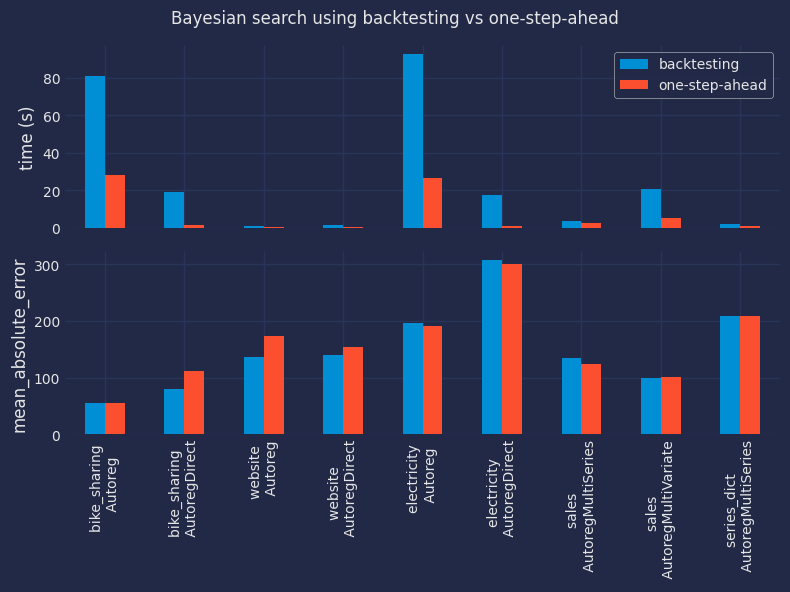

In [27]:
# Results
# ==============================================================================
summarize_results(
    results   = results_bayesian_search,
    metric    = metric,
    plot      = True,
    fig_size  = (8, 6),
    title     = 'Bayesian search using backtesting vs one-step-ahead',
    save_plot = "../img/bayesian_search_benchmarck.png"
)